In [3]:
#getting the package requirements

%matplotlib inline
import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [4]:
#importing from sklearn
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [5]:
#retrieving and loading Boston dataset
from sklearn.datasets import load_boston
boston_data = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [21]:
#opted for the housing dataset due to warnings of the boston dataset
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)

In [24]:
#get description
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [25]:
#overview of entire dataset
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [26]:
#check the features
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In this dataset, we have information regarding the demography (income, population, house occupancy) in the districts, the location of the districts (latitude, longitude), and general information regarding the house in the districts (number of rooms, number of bedrooms, age of the house). Since these statistics are at the granularity of the district, they corresponds to averages or medians.

In [27]:
#target to be predicted
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Sice it contains continous data-is a regression model

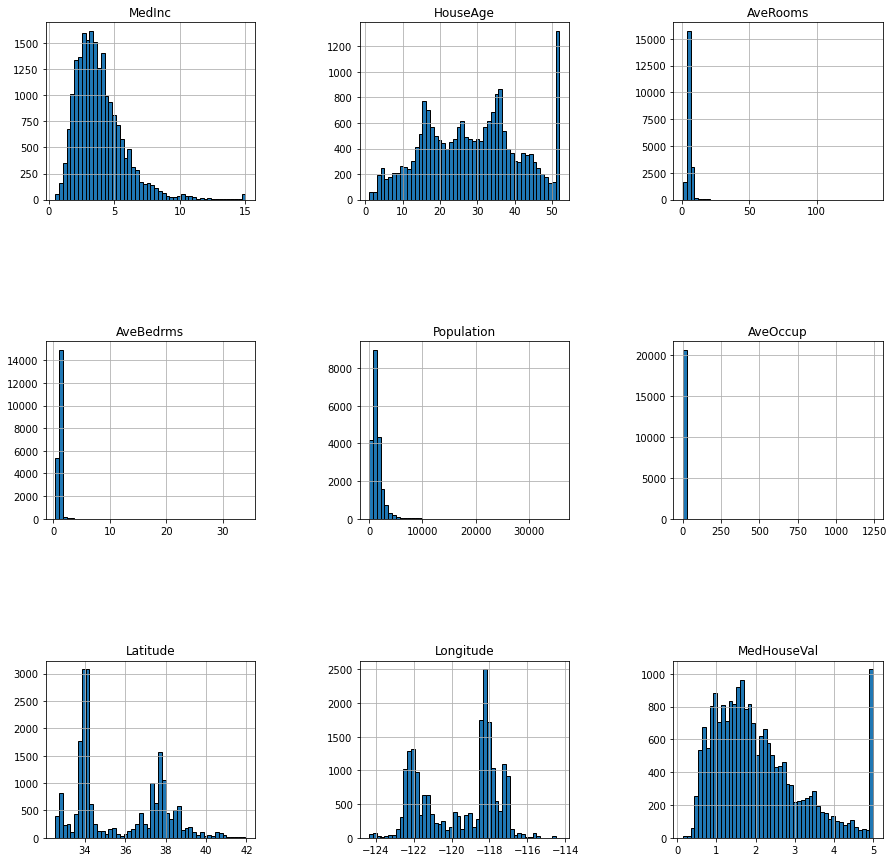

In [30]:
#understand the distribution of features
california_housing.frame.hist(figsize=(15, 15), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.8, wspace=0.5)

From the visualization above, I notice regarding the average house age, the distribution is more or less uniform.

In the median income I notice that there is an okay distribution, but no income above 15 seems strange.Most people have income between the range of 2-5

In the median_house_value which is the target in our case, there is a spike at the price of 500,000-which indicates an outlier

Focusing on the average rooms, average bedrooms, average occupation, and population, the range of the data is large with unnoticeable bin for the largest values. It means that there are very high and few values (maybe they could be considered as outliers?)

In [31]:
#getting to undrestand these columns
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


For each of these features, comparing the max and 75% values, we can see a huge difference. It confirms the intuitions that there are a couple of extreme values.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

alphas = np.logspace(-3, 1, num=30)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
cv_results = cross_validate(
    model, california_housing.data, california_housing.target,
    return_estimator=True, n_jobs=2)

In [38]:
score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} +/- {score.std():.3f}")

R2 score: 0.553 +/- 0.062


Created a linear predictive model above  and showed the values of the 
coefficients obtained via cross-validation

r2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

Another definition is (total variance explained by model) / total variance.